In [1]:
%load_ext autoreload
%autoreload 2

## import general packages
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#%matplotlib nbagg


import os, sys

## add root directory to path, to allow for imports 
root_dir = os.path.dirname(os.path.abspath(os.getcwd()))
if not root_dir in sys.path: sys.path.append(root_dir)


## import darkMatter specific packages
from darkMatter import darkMatter
from utils.plots import *
from utils.parameters import create_population_values, set_options

from empirical.model import *

In [2]:
## setting simulation parameters
steps=20
plot_ax3D=True
save=0
file_format='png'
rerun=True
compile=True

#tau_G = [0.005,0.02,0.06]
tau_G = [0.005]

{'L': 1, 'P': 2, 'S': [1, 2], 'eps': 0.7071067811865475, 'eta': 0.9, 'J0_l': array([[0.]]), 'I_ext': 1, 'rateWnt': 1.0, 'kappa': [1.0, 1.0], 'alpha_0': 0.02, 'Psi_0': 0.0, 'tau_M': 0.01, 'J0': [-1.0, 1.0], 'tau_I': [0.03, 0.005, 0.2], 'tau_n': 0, 'tau_norm': 1.0, 'mode': 0, 'mode_stats': 1, 'mode_calc': 0, 'mode_selfcon': 0, 'simulation': {'eps': [0.0, 0.7071067811865476], 'eta': [0.6], 'sim_prim': [0, -1, 0], 'sim_sec': [0, -1, 0]}}
0.9
0.6
0.2


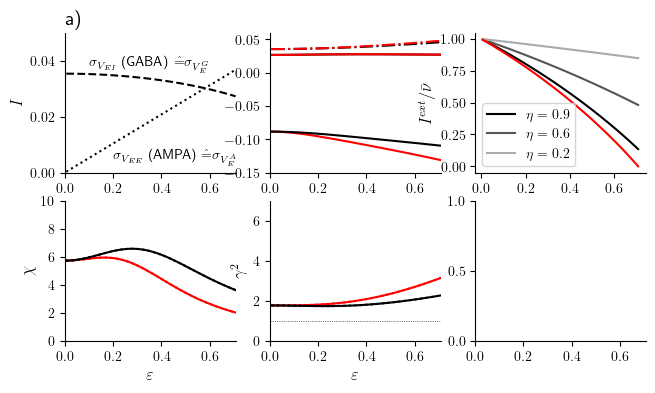

In [2]:
set_plot_params()

options = set_options(L=1,nI=1,nE=1)

options['simulation'] = {
    'eps': [0.,np.sqrt(1./2)],
    'eta': [0.6],
    'sim_prim': [0,-1,0],
    'sim_sec': [0,-1,0]
}
options['mode_stats'] = 1
options['tau_I'][0] = 0.03
options['alpha_0'] = 0.02
options['tau_n'] = 0

x_key = [o for o in list(options['simulation']) if not o.startswith('sim')][0]

plt_para = {
    'x': {
        'key': x_key,
        'lim': np.sqrt(1./2),
        },
}

res = darkMatter(steps=100,options=options,rerun=True,compile=False,logging=3)

fig, ax = plt.subplots(2,3,figsize=(7.5,4))
#ax[0,0].set_position([0.1,0.25,0.22,0.6])
#ax[0,1].set_position([0.415,0.25,0.22,0.6])
#ax[0,2].set_position([0.76,0.25,0.22,0.6])

#ax[0,0].legend(prop={'size':10},loc='lower left')
print(options)
tau_M = options['tau_M']

tau_G = options['tau_I'][0]    ## GABA
tau_A = options['tau_I'][1]    ## AMPA
tau_N = options['tau_I'][2]    ## NMDA

eps = options['eps']
eta = options['eta']

n = options['tau_n']
rateWnt = options['rateWnt']

J_EE = eta * res['eps']*tau_M
J_EI = np.sqrt(1-(eta*res['eps'])**2)*tau_M

J_IE = res['eps']*tau_M
J_II = np.sqrt(1-res['eps']**2)*tau_M

#J_EE = eta * eps*tau_M
#J_EI = np.sqrt(1-(eta*eps)**2)*tau_M

def get_var_V(J_from_E,J_from_I,rateWnt,tau_A,tau_N,tau_G,tau_M,n):
    ## variance of the membrane potential
    ## from excitatory AMPA synapses
    var_V_A = J_from_E**2 * rateWnt / (tau_A + tau_M) * ( (1-n)**2/2 + (1-n)*n*tau_A / (tau_A + tau_N) )
    ## from excitatory NMDA synapses
    var_V_N = J_from_E**2 * rateWnt / (tau_N + tau_M) * (n**2/2 + (1-n)*n*tau_N / (tau_A + tau_N) )
    ## from inhibitory GABA synapses
    var_V_G = J_from_I**2 * rateWnt * 0.5 / (tau_G + tau_M)
    return var_V_A,var_V_N,var_V_G

var_E_V_A,var_E_V_N,var_E_V_G = get_var_V(J_EE,J_EI,rateWnt,tau_A,tau_N,tau_G,tau_M,n)
var_I_V_A,var_I_V_N,var_I_V_G = get_var_V(J_IE,J_II,rateWnt,tau_A,tau_N,tau_G,tau_M,n)

# var_V_A = J_EE**2 * rateWnt / (tau_A + tau_M) * ( (1-n)**2/2 + (1-n)*n*tau_A / (tau_A + tau_N) )
# #from excitatory NMDA synapses
# var_V_N = J_EE**2 * rateWnt / (tau_N + tau_M) * (n**2/2 + (1-n)*n*tau_N / (tau_A + tau_N) );
# #from inhibitory GABA synapses
# var_V_G = J_EI**2 * rateWnt * 0.5 / (tau_G + tau_M)*np.ones_like(n)

## plot contributions of different synapses
ax[0,0].plot(res[x_key],np.sqrt(var_E_V_G),'k--',label=r'$\displaystyle \sigma_{V_E^G}$ (GABA)')
ax[0,0].plot(res[x_key],np.sqrt(var_E_V_A),'k:',label=r'$\displaystyle \sigma_{V_E^A}$ (AMPA)')
if n > 0:
    ax[0,0].plot(res[x_key],np.sqrt(var_E_V_N),'k-.',label=r'$\displaystyle \sigma_{V_E^N}$ (NMDA)')
    ax[0,0].legend(prop={'size':10},bbox_to_anchor=(0.05,1.2),loc='upper left',ncol=1)
else:
    ax[0,0].text(0.2,0.005,r'$\displaystyle \sigma_{V_{EE}}$ (AMPA) $\displaystyle \hat{=} \sigma_{V_E^A}$',fontsize=10)
    ax[0,0].text(0.1,0.038,r'$\displaystyle \sigma_{V_{EI}}$ (GABA) $\displaystyle \hat{=} \sigma_{V_E^G}$',fontsize=10)

## plot overall quenched and temporal variances
ax[0,1].plot(res[x_key],np.sqrt(var_E_V_G+var_E_V_A),'k-.')
ax[0,1].plot(res[x_key],np.sqrt(var_I_V_G+var_I_V_A),'r-.')

i=0
alpha_I = J_II**2 * res['q'][0,i,:] + J_IE**2 * res['q'][1,i,:]
alpha_E = J_EI**2 * res['q'][0,i,:] + J_EE**2 * res['q'][1,i,:]

ax[0,1].plot(res[x_key],np.sqrt(alpha_E+options['alpha_0']**2),'k')
ax[0,1].plot(res[x_key],np.sqrt(alpha_I+options['alpha_0']**2),'r')


## plot currents
ax[0,1].plot(res[x_key],-res['I_balance'][0,0,:],'r',label=r'$\displaystyle I_I$')
ax[0,1].plot(res[x_key],-res['I_balance'][1,0,:],'k',label=r'$\displaystyle I_E$')

plt.setp(ax[0][1],xticks=np.linspace(0,1,6),yticks=np.linspace(-0.15,0.05,5),xlim=[0,res[x_key][-1]],ylim=[-0.15,0.06])

## plot chi
plot_chi(ax[1,0],res,plt_para,order=0)
# ax[1,0].plot(res[x_key],res['chi'][0,2,:],'r',label=r'$\displaystyle \chi_I$')
# ax[1,0].plot(res[x_key],res['chi'][1,2,:],'k',label=r'$\displaystyle \chi_E$')
# plt.setp(ax[1,0],ylim=[0,10])

## plot gamma
plot_gamma(ax[1,1],res,plt_para,order=0)
# ax[1,1].plot(res[x_key],res['gamma'][0,2,:]**2,'r',label=r'$\displaystyle \gamma_I$')
# ax[1,1].plot(res[x_key],res['gamma'][1,2,:]**2,'k',label=r'$\displaystyle \gamma_E$')
# plt.setp(ax[1,1],ylim=[1,3.5])


options = set_options(L=1,nI=1,nE=1)

options['simulation'] = {
    'eps': [0.,np.sqrt(1./2)],
    'eta': [0.9,0.6,0.2],
    'sim_prim': [0,-1,0],
    'sim_sec': [0,-1,0]
}
options['mode_stats'] = 1
options['tau_I'][0] = 0.03
options['alpha_0'] = 0.02
options['tau_n'] = 0

x_key = 'eps'
res = darkMatter(steps=100,options=options,rerun=True,compile=False,logging=3)

# if x_key in ['eps','eta','n','tau_G']:
    #print "eps: ", res['eps'][0]
    #print "eta: ", res['eta'][0][0]
I_I_per_nu = np.sqrt(1-res['eps']**2) - res['eps']

#eta = [0.9,0.6,0.2]
for i,eta in enumerate(res['eta']):
    print(eta)
    I_E_per_nu = np.sqrt(1-(eta*res['eps'])**2) - eta*res['eps']
    col = float(i)/len(res['eta'])
    ax[0][2].plot(res[x_key],I_E_per_nu,color=(col,col,col),label=r'$\displaystyle \eta = %3.1g$'%eta)

ax[0][2].plot(res[x_key],I_I_per_nu,'r')
ax[0][2].legend(prop={'size':10},loc='lower left')
ax[0][2].set_ylabel(r'$\displaystyle I^{ext} / \bar{\nu}$')

plt.setp(ax[1][2],xticks=np.linspace(0,0.8,5),yticks=np.linspace(0,1,3),xlim=[0,res[x_key][-1]])

# ax.set_title(r'f)',position=(title_x,1.05))




if x_key == 'rate':
    plt.setp(ax[0,0],xticks=np.linspace(0,10,6),yticks=np.linspace(0,0.15,4),xlim=[0,res[x_key][-1]],ylim=[0,0.15])
else:
    #plt.setp(ax[0,0],xticks=np.linspace(0,1,6),yticks=np.linspace(0,0.075,4),xlim=[0,res[x_key][0][-1]])#,ylim=[0,0.075])
    for axx in [ax[0][0]]:#,ax[0][1]]:
        plt.setp(axx,xticks=np.linspace(0,1,6),yticks=np.linspace(0,0.04,3),xlim=[0,res[x_key][-1]],ylim=[0,0.05])
ax[0,0].set_ylabel(r'$I$')
x_title=0.05
ax[0,0].set_title(r'a)',position=(x_title,1.05))

#plt.setp(ax[0,2],ylim=[-0.15,0.],yticks=np.linspace(-0.15,0.,4))

for ax_row in ax:
    for axx in ax_row:
        axx.spines[['top','right']].set_color('none')
        #a.xaxis.set_ticks_position('bottom')
        #a.yaxis.set_ticks_position('left')

plt.show(block=False)

In [22]:
options

{'L': 1,
 'P': 2,
 'S': [1, 2],
 'eps': 0.7071067811865475,
 'eta': 0.9,
 'J0_l': array([[0.]]),
 'I_ext': 1,
 'rateWnt': 1.0,
 'kappa': [1.0, 1.0],
 'alpha_0': 0.01,
 'Psi_0': 0.0,
 'tau_M': 0.01,
 'J0': [-1.0, 1.0],
 'tau_I': [0.06, 0.005, 0.2],
 'tau_n': 0.3,
 'tau_norm': 1.0,
 'mode': 0,
 'mode_stats': 0,
 'mode_calc': 0,
 'mode_selfcon': 0,
 'simulation': {'rateWnt': [0.0, 10.0],
  'alpha_0': [0.0, 0.05],
  'sim_prim': [0, -1, 0],
  'sim_sec': [0, -1, 0]}}

In [17]:
res['gamma'][0][20,:]#[:20,:2].data

masked_array(data=[0.56329098, 0.74599505, 0.8718677 , 0.96644882,
                   1.03890552, 1.0941064 , 1.13526628, 1.16484968,
                   1.18490299, 1.19719114, 1.20325352, 1.20445267,
                   1.20186031, 1.19648645, 1.18910936, 1.18035254,
                   1.17070405, 1.16053727, 1.15013136, 1.13969016,
                   1.12935878, 1.11923749, 1.10939287, 1.09986667,
                   1.0906825 , 1.08185032, 1.07337758, 1.06524537,
                   1.05745725, 1.04999733, 1.04285208, 1.03600708,
                   1.0294476 , 1.02315896, 1.01712679, 1.0113372 ,
                   1.00577691, 1.00043324, 0.99529423, 0.99034857,
                   0.98558564, 0.98099546, 0.97656868, 0.97229653,
                   0.96817081, 0.96418384, 0.96032844, 0.95659321,
                   0.95298305, 0.94948492, 0.94609347, 0.94280365,
                   0.93961073, 0.93651022, 0.93349791, 0.93056981,
                   0.92772217, 0.92495143, 0.92225425, 0.91962

In [10]:
res['np_trans']#[0]#[:20,:2].data

masked_array(
  data=[[[--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --],
         [--, --]